In [1498]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as sps


sns.set()
pd.set_option("display.precision", 2)

# SCRAPES THE LATEST DATA FROM WORLDOMETERS
url = 'https://www.worldometers.info/coronavirus/#countries'

r = requests.get(url)

c = r.content

soup = bs(c,'html.parser')

foo = soup.findAll('div',{'class' : 'tab-content'})
print (len(foo))

the_div = foo[2]

tbody = the_div.tbody

rows = tbody.findAll('tr')

countries = dict()

for r in rows:
    td = r.findAll('td')
    name = td[0].get_text().strip()
    confirmed = td[1].get_text().strip()
    inc = td[2].get_text().strip()
    deaths = td[3].get_text().strip()
    d_inc = td[4].get_text().strip()
    recovered = td[5].get_text().strip()
    active_cases = td[6].get_text().strip()
    serious = td[7].get_text().strip()
    conf_p_M = td[8].get_text().strip()
    countries[name] = [confirmed,inc,deaths,d_inc,
                       recovered,active_cases,serious,conf_p_M]
    
cols = ['confirmed','inc','dead','dead_inc','recovered',
        'active_cases','serious','confirmed_per_M']

df = pd.DataFrame.from_dict(countries)
df = df.T
df.columns = cols

df[['inc','dead_inc']] = df[['inc','dead_inc']].apply(
    lambda x : x.str.replace('+',''))

df[['confirmed','dead','recovered','active_cases',
    'serious','inc','dead_inc','confirmed_per_M']] = \
    df[['confirmed','dead','recovered','active_cases',
        'serious','inc','dead_inc','confirmed_per_M']].apply(
    lambda x : x.str.replace(',',''))

df[cols] = df[cols].apply(lambda x: x.replace('',np.nan))


df[cols] = df[cols].astype(float)
df['yesterday'] = df['confirmed'] - df['inc']
df['factor'] = df['confirmed'] / df['yesterday']
cols  = ['confirmed', 'yesterday','inc', 'factor','dead', 'dead_inc', 'recovered', 'active_cases',
       'serious', 'confirmed_per_M']

df = df[cols]

#df['factor'].loc[df['factor'] == np.inf]
df['factor'] = df['factor'].replace(np.inf,np.nan)
df['dead_pct'] = 100 * df['dead'] / df['confirmed']
df['dead'] = df['dead'].fillna(0)
df['dead_factor'] = df['dead'].div (df['dead'] - df['dead_inc'])
df['dead_factor'].replace(np.inf,np.nan,inplace=True)
df.head(40)


3


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor
USA,142735.0,142460.0,275.0,1.00,2488.0,4.0,4559.0,135688.0,2970.0,431.0,1.74,1.00
Italy,97689.0,NaN,NaN,NaN,10779.0,NaN,13030.0,73880.0,3906.0,1616.0,11.03,NaN
Spain,80110.0,NaN,NaN,NaN,6803.0,NaN,14709.0,58598.0,4165.0,1713.0,8.49,NaN
Germany,62435.0,NaN,NaN,NaN,541.0,NaN,9211.0,52683.0,1979.0,745.0,0.87,NaN
France,40174.0,NaN,NaN,NaN,2606.0,NaN,7202.0,30366.0,4632.0,615.0,6.49,NaN
Iran,38309.0,NaN,NaN,NaN,2640.0,NaN,12391.0,23278.0,3206.0,456.0,6.89,NaN
UK,19522.0,NaN,NaN,NaN,1228.0,NaN,135.0,18159.0,163.0,288.0,6.29,NaN
Switzerland,14829.0,NaN,NaN,NaN,300.0,NaN,1595.0,12934.0,301.0,1713.0,2.02,NaN
Netherlands,10866.0,NaN,NaN,NaN,771.0,NaN,250.0,9845.0,972.0,634.0,7.10,NaN
Belgium,10836.0,NaN,NaN,NaN,431.0,NaN,1359.0,9046.0,867.0,935.0,3.98,NaN


In [1499]:
df.to_pickle('scrape_df.pkl')
df.agg(['sum','max','min','mean','median','count'])


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor
sum,723279.0,239784.0,920.0,17.62,33993.00,27.00,151800.00,537486.00,26707.00,59364.60,487.78,8.86
max,142735.0,142460.0,275.0,1.26,10779.00,6.00,75700.00,135688.00,4632.00,7491.00,28.57,1.29
min,1.0,24.0,3.0,1.00,0.00,1.00,1.00,0.00,1.00,0.10,0.16,1.00
mean,3598.4,14986.5,57.5,1.10,169.12,3.38,1124.44,2674.06,269.77,298.31,3.93,1.11
median,120.0,461.0,30.0,1.09,1.00,4.00,17.00,107.00,10.00,38.00,2.17,1.07
count,201.0,16.0,16.0,16.00,201.00,8.00,135.00,201.00,99.00,199.00,124.00,8.00


In [1500]:
today = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')
file_prefix = 'snapshots/corona_snapshot_'
filename = file_prefix + today.replace(' ','_').replace(':','_') + '.pkl'
df['datetime'] = [today] * len(df)
df.set_index([df.index,'datetime'],drop=True).to_pickle(filename)
df.head()

/usr/lib/python3.6/site-packages/IPython/core/displayhook.py:260: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,datetime
USA,142735.0,142460.0,275.0,1.0,2488.0,4.0,4559.0,135688.0,2970.0,431.0,1.74,1.0,2020-03-30 08:06:16
Italy,97689.0,NaN,NaN,NaN,10779.0,NaN,13030.0,73880.0,3906.0,1616.0,11.03,NaN,2020-03-30 08:06:16
Spain,80110.0,NaN,NaN,NaN,6803.0,NaN,14709.0,58598.0,4165.0,1713.0,8.49,NaN,2020-03-30 08:06:16
Germany,62435.0,NaN,NaN,NaN,541.0,NaN,9211.0,52683.0,1979.0,745.0,0.87,NaN,2020-03-30 08:06:16
France,40174.0,NaN,NaN,NaN,2606.0,NaN,7202.0,30366.0,4632.0,615.0,6.49,NaN,2020-03-30 08:06:16


In [1501]:
import glob
files = [f for f in glob.glob('./' + file_prefix +'*')]

timeline_df = pd.DataFrame()

for f in files:
    temp = pd.read_pickle(f)
    timeline_df = pd.concat([timeline_df,temp],axis=0)
    
timeline_df.sort_index(inplace=True)
timeline_df['dead'] = timeline_df['dead'].fillna(0)
timeline_df

confirmed  yesterday  inc  factor  dead  \
            datetime                                                       
Afghanistan 2020-03-15 15:50:08       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 16:55:44       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 19:43:02       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 21:46:07       16.0       11.0  5.0    1.45   0.0   
            2020-03-15 22:21:09       16.0       11.0  5.0    1.45   0.0   
...                                    ...        ...  ...     ...   ...   
Zimbabwe    2020-03-29 20:06:34        7.0        NaN  NaN     NaN   1.0   
            2020-03-29 21:08:04        7.0        NaN  NaN     NaN   1.0   
            2020-03-29 21:29:35        7.0        NaN  NaN     NaN   1.0   
            2020-03-29 21:49:06        7.0        NaN  NaN     NaN   1.0   
            2020-03-30 08:06:16        7.0        NaN  NaN     NaN   1.0   

                                 dead_inc  recovered  active_cases  serious  \
            datetime                                                          
Afghanistan 2020-03-15 15:50:08       NaN        1.0          15.0      NaN   
            2020-03-15 16:55:44       NaN        1.0          15.0      NaN   
            2020-03-15 19:43:02       NaN        1.0          15.0      NaN   
            2020-03-15 21:46:07       NaN        1.0          15.0      NaN   
            2020-03-15 22:21:09       NaN        1.0          15.0      NaN   
...                                   ...        ...           ...      ...   
Zimbabwe    2020-03-29 20:06:34       NaN        NaN           6.0      NaN   
            2020-03-29 21:08:04       NaN        NaN           6.0      NaN   
            2020-03-29 21:29:35       NaN        NaN           6.0      NaN   
            2020-03-29 21:49:06       NaN        NaN           6.0      NaN   
            2020-03-30 08:06:16       NaN        NaN           6.0      NaN   

                                 confirmed_per_M  dead_pct  dead_factor  
            datetime                                                     
Afghanistan 2020-03-15 15:50:08              0.4       NaN          NaN  
            2020-03-15 16:55:44              0.4       NaN          NaN  
            2020-03-15 19:43:02              0.4       NaN          NaN  
            2020-03-15 21:46:07              0.4       NaN          NaN  
            2020-03-15 22:21:09              0.4       NaN          NaN  
...                                          ...       ...          ...  
Zimbabwe    2020-03-29 20:06:34              0.5     14.29          NaN  
            2020-03-29 21:08:04              0.5     14.29          NaN  
            2020-03-29 21:29:35              0.5     14.29          NaN  
            2020-03-29 21:49:06              0.5     14.29          NaN  
            2020-03-30 08:06:16              0.5     14.29          NaN  

[30676 rows x 12 columns]

In [1502]:
timeline_group = timeline_df.groupby(level=0)

a_country = timeline_group.get_group('USA')
a_country

confirmed  yesterday      inc  factor    dead  \
    datetime                                                             
USA 2020-03-15 15:50:08     3083.0     2943.0    140.0    1.05    60.0   
    2020-03-15 16:55:44     3094.0     2943.0    151.0    1.05    62.0   
    2020-03-15 19:43:02     3326.0     2943.0    383.0    1.13    63.0   
    2020-03-15 21:46:07     3457.0     2943.0    514.0    1.17    63.0   
    2020-03-15 22:21:09     3621.0     2943.0    678.0    1.23    63.0   
...                            ...        ...      ...     ...     ...   
    2020-03-29 20:06:34   133240.0   123578.0   9662.0    1.08  2363.0   
    2020-03-29 21:08:04   135899.0   123578.0  12321.0    1.10  2389.0   
    2020-03-29 21:29:35   135957.0   123578.0  12379.0    1.10  2391.0   
    2020-03-29 21:49:06   137943.0   123578.0  14365.0    1.12  2431.0   
    2020-03-30 08:06:16   142735.0   142460.0    275.0    1.00  2488.0   

                         dead_inc  recovered  active_cases  serious  \
    datetime                                                          
USA 2020-03-15 15:50:08       3.0       56.0        2967.0     10.0   
    2020-03-15 16:55:44       5.0       56.0        2976.0     10.0   
    2020-03-15 19:43:02       6.0       59.0        3204.0     10.0   
    2020-03-15 21:46:07       6.0       59.0        3335.0     10.0   
    2020-03-15 22:21:09       6.0       59.0        3499.0     10.0   
...                           ...        ...           ...      ...   
    2020-03-29 20:06:34     143.0     4378.0      126499.0   2948.0   
    2020-03-29 21:08:04     169.0     4378.0      129132.0   2948.0   
    2020-03-29 21:29:35     171.0     4378.0      129188.0   2948.0   
    2020-03-29 21:49:06     211.0     4430.0      131082.0   2948.0   
    2020-03-30 08:06:16       4.0     4559.0      135688.0   2970.0   

                         confirmed_per_M  dead_pct  dead_factor  
    datetime                                                     
USA 2020-03-15 15:50:08              9.3      1.95          NaN  
    2020-03-15 16:55:44              9.3      2.00          NaN  
    2020-03-15 19:43:02             10.0      1.89          NaN  
    2020-03-15 21:46:07             10.4      1.82          NaN  
    2020-03-15 22:21:09             10.9      1.74          NaN  
...                                  ...       ...          ...  
    2020-03-29 20:06:34            403.0      1.77         1.06  
    2020-03-29 21:08:04            411.0      1.76         1.08  
    2020-03-29 21:29:35            411.0      1.76         1.08  
    2020-03-29 21:49:06            417.0      1.76         1.10  
    2020-03-30 08:06:16            431.0      1.74         1.00  

[168 rows x 12 columns]

In [1503]:
non_duplicates = ( ( a_country['confirmed'] != a_country['confirmed'].shift() )  | (
    a_country['dead'] != a_country['dead'].shift()))

a_country = a_country[non_duplicates]
a_country

confirmed  yesterday      inc  factor    dead  \
    datetime                                                             
USA 2020-03-15 15:50:08     3083.0     2943.0    140.0    1.05    60.0   
    2020-03-15 16:55:44     3094.0     2943.0    151.0    1.05    62.0   
    2020-03-15 19:43:02     3326.0     2943.0    383.0    1.13    63.0   
    2020-03-15 21:46:07     3457.0     2943.0    514.0    1.17    63.0   
    2020-03-15 22:21:09     3621.0     2943.0    678.0    1.23    63.0   
...                            ...        ...      ...     ...     ...   
    2020-03-29 20:06:34   133240.0   123578.0   9662.0    1.08  2363.0   
    2020-03-29 21:08:04   135899.0   123578.0  12321.0    1.10  2389.0   
    2020-03-29 21:29:35   135957.0   123578.0  12379.0    1.10  2391.0   
    2020-03-29 21:49:06   137943.0   123578.0  14365.0    1.12  2431.0   
    2020-03-30 08:06:16   142735.0   142460.0    275.0    1.00  2488.0   

                         dead_inc  recovered  active_cases  serious  \
    datetime                                                          
USA 2020-03-15 15:50:08       3.0       56.0        2967.0     10.0   
    2020-03-15 16:55:44       5.0       56.0        2976.0     10.0   
    2020-03-15 19:43:02       6.0       59.0        3204.0     10.0   
    2020-03-15 21:46:07       6.0       59.0        3335.0     10.0   
    2020-03-15 22:21:09       6.0       59.0        3499.0     10.0   
...                           ...        ...           ...      ...   
    2020-03-29 20:06:34     143.0     4378.0      126499.0   2948.0   
    2020-03-29 21:08:04     169.0     4378.0      129132.0   2948.0   
    2020-03-29 21:29:35     171.0     4378.0      129188.0   2948.0   
    2020-03-29 21:49:06     211.0     4430.0      131082.0   2948.0   
    2020-03-30 08:06:16       4.0     4559.0      135688.0   2970.0   

                         confirmed_per_M  dead_pct  dead_factor  
    datetime                                                     
USA 2020-03-15 15:50:08              9.3      1.95          NaN  
    2020-03-15 16:55:44              9.3      2.00          NaN  
    2020-03-15 19:43:02             10.0      1.89          NaN  
    2020-03-15 21:46:07             10.4      1.82          NaN  
    2020-03-15 22:21:09             10.9      1.74          NaN  
...                                  ...       ...          ...  
    2020-03-29 20:06:34            403.0      1.77         1.06  
    2020-03-29 21:08:04            411.0      1.76         1.08  
    2020-03-29 21:29:35            411.0      1.76         1.08  
    2020-03-29 21:49:06            417.0      1.76         1.10  
    2020-03-30 08:06:16            431.0      1.74         1.00  

[127 rows x 12 columns]

In [1504]:
resample = a_country.droplevel(0)
resample.index = pd.DatetimeIndex(resample.index)
#resample = resample.resample('180T').bfill()
resample = resample.resample('D').bfill()

index = pd.to_datetime(resample.index)

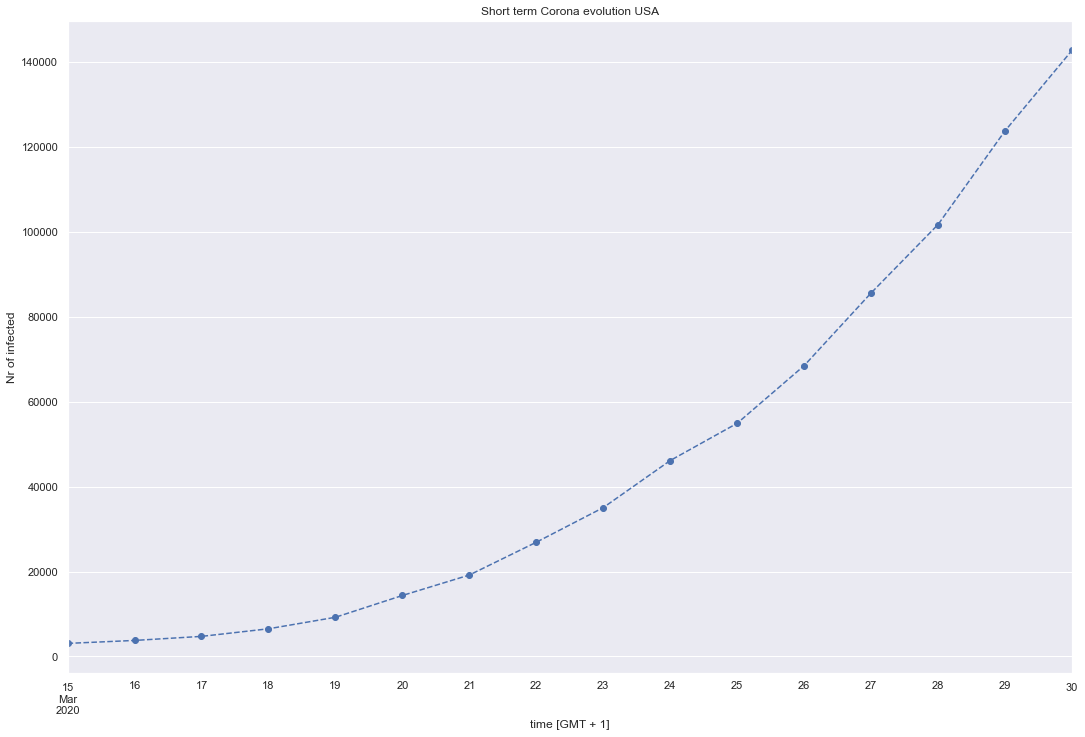

In [1505]:


plt.figure(figsize=(18,12))
plt.title('Short term Corona evolution {}'.format(a_country.index[0][0]))
resample['confirmed'].plot(style ='o--')
#plt.xticks(rotation=90)
#plt.xticks(np.arange(len(index)),index.values)
plt.xlabel('time [GMT + 1]')

plt.ylabel('Nr of infected')
#plt.ylabel(r'Nr of infected [ $10^{x}$ ]')
#plt.yscale('log')

filename = 'corona_short_term_' + a_country.index[0][0] + '.jpg'
plt.savefig (filename,format='jpg')


In [1506]:
top_dead_pct = df.loc[df['confirmed'] > 500].sort_values('dead_pct',ascending=False)
top_dead_pct

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,datetime
Italy,97689.0,NaN,NaN,NaN,10779.0,NaN,13030.0,73880.0,3906.0,1616.0,11.03,NaN,2020-03-30 08:06:16
Indonesia,1285.0,NaN,NaN,NaN,114.0,NaN,64.0,1107.0,NaN,5.0,8.87,NaN,2020-03-30 08:06:16
Spain,80110.0,NaN,NaN,NaN,6803.0,NaN,14709.0,58598.0,4165.0,1713.0,8.49,NaN,2020-03-30 08:06:16
Iraq,547.0,NaN,NaN,NaN,42.0,NaN,143.0,362.0,NaN,14.0,7.68,NaN,2020-03-30 08:06:16
Netherlands,10866.0,NaN,NaN,NaN,771.0,NaN,250.0,9845.0,972.0,634.0,7.10,NaN,2020-03-30 08:06:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chile,2139.0,NaN,NaN,NaN,7.0,NaN,75.0,2057.0,7.0,112.0,0.33,NaN,2020-03-30 08:06:16
Iceland,1020.0,NaN,NaN,NaN,2.0,NaN,135.0,883.0,25.0,2989.0,0.20,NaN,2020-03-30 08:06:16
New Zealand,589.0,514.0,75.0,1.15,1.0,NaN,63.0,525.0,2.0,122.0,0.17,NaN,2020-03-30 08:06:16
Qatar,634.0,NaN,NaN,NaN,1.0,NaN,48.0,585.0,6.0,220.0,0.16,NaN,2020-03-30 08:06:16


In [1507]:
country_names = sorted(df.index.values)
#country_names

In [1508]:
df.loc[df['confirmed'] > 500 ].sort_values('factor',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,datetime
Mexico,993.0,848.0,145.0,1.17,20.0,4.0,35.0,938.0,1.0,8.0,2.01,1.25,2020-03-30 08:06:16
New Zealand,589.0,514.0,75.0,1.15,1.0,NaN,63.0,525.0,2.0,122.0,0.17,NaN,2020-03-30 08:06:16
Thailand,1524.0,1388.0,136.0,1.10,7.0,NaN,229.0,1288.0,11.0,22.0,0.46,NaN,2020-03-30 08:06:16
India,1071.0,1024.0,47.0,1.05,29.0,2.0,100.0,942.0,NaN,0.8,2.71,1.07,2020-03-30 08:06:16
Pakistan,1625.0,1597.0,28.0,1.02,18.0,4.0,29.0,1578.0,11.0,7.0,1.11,1.29,2020-03-30 08:06:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Qatar,634.0,NaN,NaN,NaN,1.0,NaN,48.0,585.0,6.0,220.0,0.16,NaN,2020-03-30 08:06:16
Egypt,609.0,NaN,NaN,NaN,40.0,NaN,132.0,437.0,NaN,6.0,6.57,NaN,2020-03-30 08:06:16
UAE,570.0,NaN,NaN,NaN,3.0,NaN,58.0,509.0,2.0,58.0,0.53,NaN,2020-03-30 08:06:16
Iraq,547.0,NaN,NaN,NaN,42.0,NaN,143.0,362.0,NaN,14.0,7.68,NaN,2020-03-30 08:06:16


In [1509]:
top_10_per_m = df.sort_values('confirmed_per_M',ascending=False).head(10)
top_10_per_m

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,datetime
Vatican City,6.0,NaN,NaN,NaN,0.0,NaN,NaN,6.0,NaN,7491.0,NaN,NaN,2020-03-30 08:06:16
San Marino,224.0,NaN,NaN,NaN,22.0,NaN,6.0,196.0,16.0,6602.0,9.82,NaN,2020-03-30 08:06:16
Andorra,334.0,NaN,NaN,NaN,6.0,NaN,1.0,327.0,10.0,4323.0,1.80,NaN,2020-03-30 08:06:16
Faeroe Islands,159.0,NaN,NaN,NaN,0.0,NaN,70.0,89.0,1.0,3254.0,NaN,NaN,2020-03-30 08:06:16
Luxembourg,1950.0,NaN,NaN,NaN,21.0,NaN,40.0,1889.0,25.0,3115.0,1.08,NaN,2020-03-30 08:06:16
Iceland,1020.0,NaN,NaN,NaN,2.0,NaN,135.0,883.0,25.0,2989.0,0.20,NaN,2020-03-30 08:06:16
Gibraltar,65.0,NaN,NaN,NaN,0.0,NaN,14.0,51.0,NaN,1929.0,NaN,NaN,2020-03-30 08:06:16
Spain,80110.0,NaN,NaN,NaN,6803.0,NaN,14709.0,58598.0,4165.0,1713.0,8.49,NaN,2020-03-30 08:06:16
Switzerland,14829.0,NaN,NaN,NaN,300.0,NaN,1595.0,12934.0,301.0,1713.0,2.02,NaN,2020-03-30 08:06:16
Italy,97689.0,NaN,NaN,NaN,10779.0,NaN,13030.0,73880.0,3906.0,1616.0,11.03,NaN,2020-03-30 08:06:16


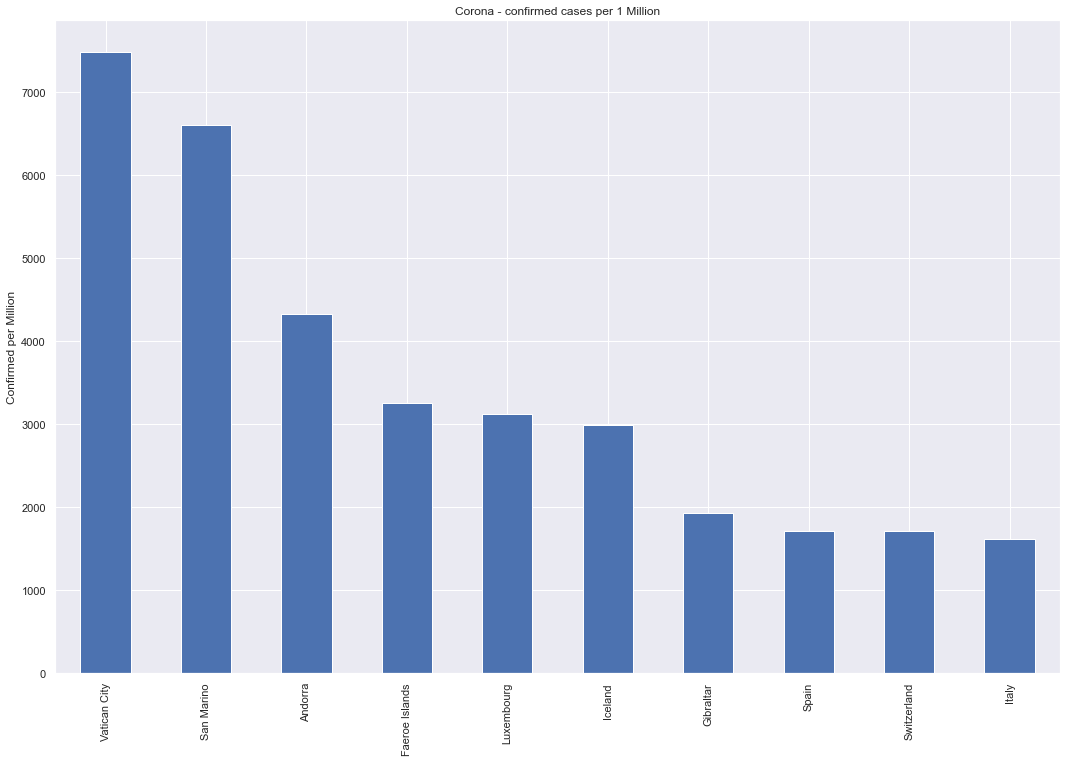

In [1510]:
plt.figure(figsize=(18,12))
plt.title('Corona - confirmed cases per 1 Million')
plt.ylabel ('Confirmed per Million')
top_10_per_m['confirmed_per_M'].plot(kind='bar')
plt.savefig('confirmed_per_million.jpg',format='jpg')

In [1511]:
totals = pd.DataFrame(df.sum(),columns=['totals'])
totals.drop(['factor','confirmed_per_M','dead_pct','datetime'],inplace=True)
totals

,totals
confirmed,7.2e+05
yesterday,2.4e+05
inc,9.2e+02
dead,3.4e+04
dead_inc,27
recovered,1.5e+05
active_cases,5.4e+05
serious,2.7e+04
dead_factor,8.9


In [1512]:
country_names = list(sorted((df.index.unique().values)))
country_names

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'CAR',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'DRC',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faeroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'French Polynesia',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Gr

In [1513]:
some_countries = ['Sweden','USA','Italy','Spain','Norway','Finland',
                  'Denmark','Singapore','S. Korea','China','Russia',
                 'Poland','Taiwan','Estonia','Germany','Austria','Belgium','France','Canada','Japan']
countries_of_interest = df.loc[some_countries,:]
countries_of_interest.sort_values('confirmed',inplace=True,ascending=False)
countries_of_interest

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,datetime
USA,142735.0,142460.0,275.0,1.00,2488.0,4.0,4559.0,135688.0,2970.0,431.0,1.74,1.00,2020-03-30 08:06:16
Italy,97689.0,NaN,NaN,NaN,10779.0,NaN,13030.0,73880.0,3906.0,1616.0,11.03,NaN,2020-03-30 08:06:16
China,81470.0,81439.0,31.0,1.00,3304.0,4.0,75700.0,2466.0,633.0,57.0,4.06,1.00,2020-03-30 08:06:16
Spain,80110.0,NaN,NaN,NaN,6803.0,NaN,14709.0,58598.0,4165.0,1713.0,8.49,NaN,2020-03-30 08:06:16
Germany,62435.0,NaN,NaN,NaN,541.0,NaN,9211.0,52683.0,1979.0,745.0,0.87,NaN,2020-03-30 08:06:16
France,40174.0,NaN,NaN,NaN,2606.0,NaN,7202.0,30366.0,4632.0,615.0,6.49,NaN,2020-03-30 08:06:16
Belgium,10836.0,NaN,NaN,NaN,431.0,NaN,1359.0,9046.0,867.0,935.0,3.98,NaN,2020-03-30 08:06:16
S. Korea,9661.0,9583.0,78.0,1.01,158.0,6.0,5228.0,4275.0,59.0,188.0,1.64,1.04,2020-03-30 08:06:16
Austria,8788.0,NaN,NaN,NaN,86.0,NaN,479.0,8223.0,187.0,976.0,0.98,NaN,2020-03-30 08:06:16
Canada,6320.0,NaN,NaN,NaN,65.0,NaN,573.0,5682.0,120.0,167.0,1.03,NaN,2020-03-30 08:06:16


In [1514]:
countries_of_interest.sort_values('confirmed_per_M',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,datetime
Spain,80110.0,NaN,NaN,NaN,6803.0,NaN,14709.0,58598.0,4165.0,1713.0,8.49,NaN,2020-03-30 08:06:16
Italy,97689.0,NaN,NaN,NaN,10779.0,NaN,13030.0,73880.0,3906.0,1616.0,11.03,NaN,2020-03-30 08:06:16
Austria,8788.0,NaN,NaN,NaN,86.0,NaN,479.0,8223.0,187.0,976.0,0.98,NaN,2020-03-30 08:06:16
Belgium,10836.0,NaN,NaN,NaN,431.0,NaN,1359.0,9046.0,867.0,935.0,3.98,NaN,2020-03-30 08:06:16
Norway,4284.0,NaN,NaN,NaN,26.0,NaN,7.0,4251.0,91.0,790.0,0.61,NaN,2020-03-30 08:06:16
Germany,62435.0,NaN,NaN,NaN,541.0,NaN,9211.0,52683.0,1979.0,745.0,0.87,NaN,2020-03-30 08:06:16
France,40174.0,NaN,NaN,NaN,2606.0,NaN,7202.0,30366.0,4632.0,615.0,6.49,NaN,2020-03-30 08:06:16
Estonia,679.0,NaN,NaN,NaN,3.0,NaN,20.0,656.0,10.0,512.0,0.44,NaN,2020-03-30 08:06:16
USA,142735.0,142460.0,275.0,1.00,2488.0,4.0,4559.0,135688.0,2970.0,431.0,1.74,1.00,2020-03-30 08:06:16
Denmark,2395.0,NaN,NaN,NaN,72.0,NaN,1.0,2322.0,113.0,413.0,3.01,NaN,2020-03-30 08:06:16


In [1515]:
european_countries = pd.read_csv('european_countries.csv',sep=';',
                     encoding='ISO-8859-1',header=None,
                     names=['country','population','region'],
                    thousands=',')
europe_names = list(european_countries['country'].values)

try:
    europe = df.loc[europe_names,:]
except KeyError:
    print ('some country from european_countries missing from dataset')
    
europe.sort_values('confirmed',ascending=False,inplace=True)
europe

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,datetime
Italy,97689.0,NaN,NaN,NaN,10779.0,NaN,13030.0,73880.0,3906.0,1616.0,11.03,NaN,2020-03-30 08:06:16
Spain,80110.0,NaN,NaN,NaN,6803.0,NaN,14709.0,58598.0,4165.0,1713.0,8.49,NaN,2020-03-30 08:06:16
Germany,62435.0,NaN,NaN,NaN,541.0,NaN,9211.0,52683.0,1979.0,745.0,0.87,NaN,2020-03-30 08:06:16
France,40174.0,NaN,NaN,NaN,2606.0,NaN,7202.0,30366.0,4632.0,615.0,6.49,NaN,2020-03-30 08:06:16
UK,19522.0,NaN,NaN,NaN,1228.0,NaN,135.0,18159.0,163.0,288.0,6.29,NaN,2020-03-30 08:06:16
Switzerland,14829.0,NaN,NaN,NaN,300.0,NaN,1595.0,12934.0,301.0,1713.0,2.02,NaN,2020-03-30 08:06:16
Netherlands,10866.0,NaN,NaN,NaN,771.0,NaN,250.0,9845.0,972.0,634.0,7.10,NaN,2020-03-30 08:06:16
Belgium,10836.0,NaN,NaN,NaN,431.0,NaN,1359.0,9046.0,867.0,935.0,3.98,NaN,2020-03-30 08:06:16
Austria,8788.0,NaN,NaN,NaN,86.0,NaN,479.0,8223.0,187.0,976.0,0.98,NaN,2020-03-30 08:06:16
Portugal,5962.0,NaN,NaN,NaN,119.0,NaN,43.0,5800.0,89.0,585.0,2.00,NaN,2020-03-30 08:06:16


In [1516]:
europe_sum = europe[['confirmed','yesterday','inc','dead','dead_inc','recovered','active_cases']].sum()
europe_sum

confirmed       384904.0
yesterday          408.0
inc                 39.0
dead             24207.0
dead_inc             2.0
recovered        48840.0
active_cases    311857.0
dtype: float64

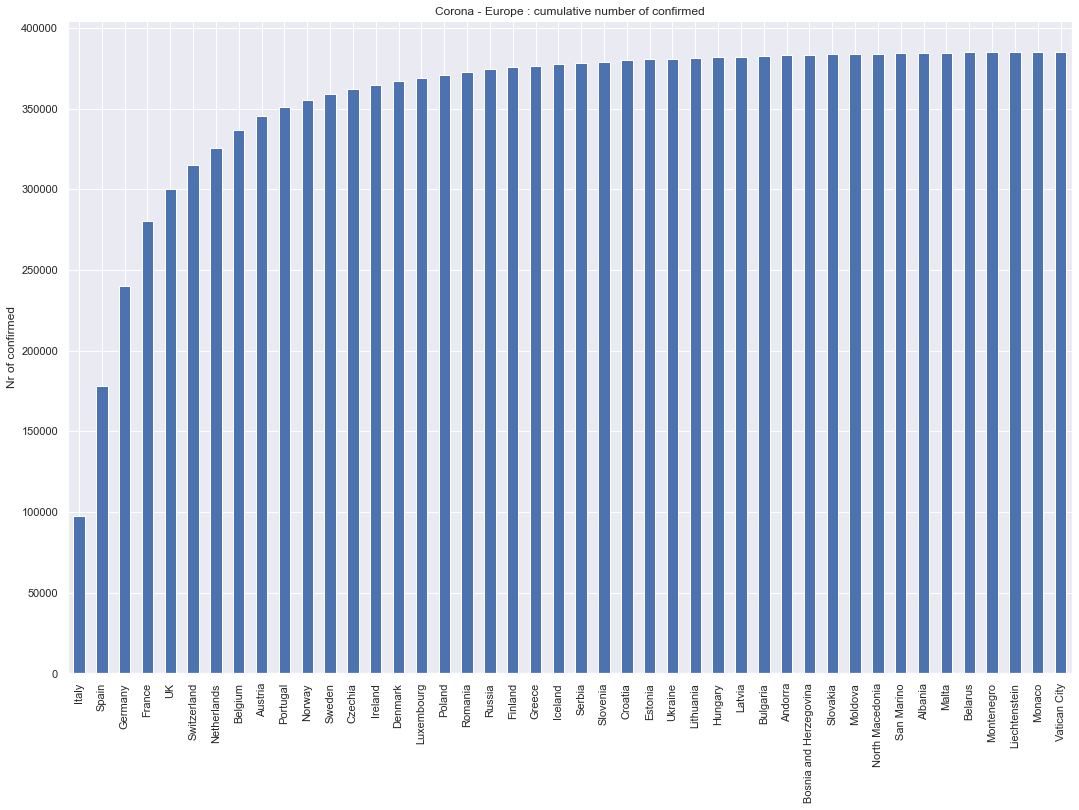

In [1517]:
plt.figure(figsize=(18,12))
europe['confirmed'].cumsum().plot(kind='bar')
plt.title('Corona - Europe : cumulative number of confirmed')
plt.ylabel('Nr of confirmed')
plt.savefig('Corona_europe_cumulative.jpg',format='jpg')


In [1518]:
def standardize(x):
    return (x - x.mean()) / x.std()

min_confirmed = 100
max_confirmed = 100000 # exclude e.g. China for better view

df_no_extrems = df.loc[ ( ( df['confirmed'] > min_confirmed  ) & ( df['confirmed'] < max_confirmed )) ]
df_no_extrems = df_no_extrems.loc[df_no_extrems['factor'] > 0]
df_no_extrems = df_no_extrems.loc[( 
    ( df_no_extrems['confirmed'] >= min_confirmed ) & (df_no_extrems['confirmed'] <= max_confirmed))]

x = df_no_extrems['confirmed_per_M']
x = standardize(x)
y = df_no_extrems['factor']
y = standardize(y)

In [1519]:
# 

slope,intercept,_,_,_ = sps.linregress(x,y)

alpha_mu = 0
alpha_sigma = 1
beta_mu = 0
beta_sigma = 1


alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu,tau = 1 / beta_sigma ** 2)

# by changing sigma from uniform to lognormal, the y-range of sample plot below
# shrunk a lot

sigma = pm.Uniform('sigma',lower=0,upper=10)

@pm.deterministic()
def linreq_mu(x=x,beta=beta,alpha=alpha):
    return x * beta + alpha

likelihood  = pm.Normal('likelihood',mu=linreq_mu,tau= 1 / sigma ** 2,
                       observed=True,value=y)

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

mcmc.sample(10000,5000,2)

alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]
sigma_samples = mcmc.trace('sigma')[:]
linreq_mu_samples = mcmc.trace('sigma')[:]

result = pd.DataFrame({'alpha_post': alpha_samples,
                     'beta_post' : beta_samples,
                     'sigma_post' : sigma_samples,
                     'linreq_mu_post' : linreq_mu_samples})


 [-----------------100%-----------------] 10000 of 10000 complete in 9.3 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2.50e+03,2500.00,2500.00,2500.00
mean,-7.96e-02,-0.23,1.14,1.14
std,2.56e-01,0.34,0.30,0.30
min,-1.30e+00,-2.17,0.55,0.55
25%,-1.89e-01,-0.43,0.93,0.93
50%,-5.78e-02,-0.22,1.07,1.07
75%,4.16e-03,-0.01,1.28,1.28
max,9.70e-01,1.18,3.13,3.13


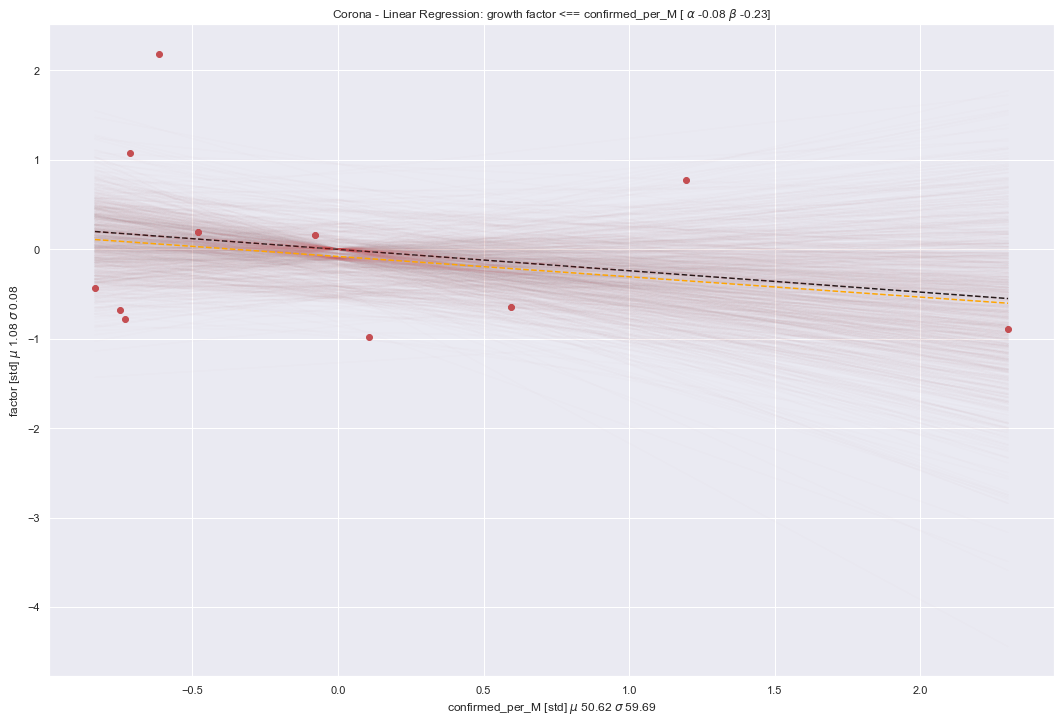

In [1520]:

nr_rows = 100
nr_samples = 1000

alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_samples)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_samples)

X = np.linspace(x.min(),x.max(),nr_rows)

line_ys = np.array([X[i] * betas + alphas for i in range(len(X))])

plt.figure(figsize=(18,12))

line_alpha = result['alpha_post'].mean()
line_beta = result['beta_post'].mean()

plt.title(r'Corona - Linear Regression: growth factor <== confirmed_per_M [ $\alpha$ {:.2f} $\beta$ {:.2f}]'.format(
                                                                                        line_alpha,line_beta))

plt.ylabel(r'factor [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['factor'].mean(),
                                                              df_no_extrems['factor'].std()))
plt.xlabel(r'confirmed_per_M [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['confirmed_per_M'].mean(),
                                                             df_no_extrems['confirmed_per_M'].std()))
plt.scatter(x,y,color='r')
plt.plot(X,[X[i] * slope + intercept for i in range(len(X))],color='k',ls='dashed')
plt.plot(X,line_ys,color='r',alpha = 0.01)
plt.plot(X,[X[i] * result['beta_post'].mean() + result['alpha_post'].mean() for i in range(len(X))],
        color='orange',ls='dashed')
result.describe()


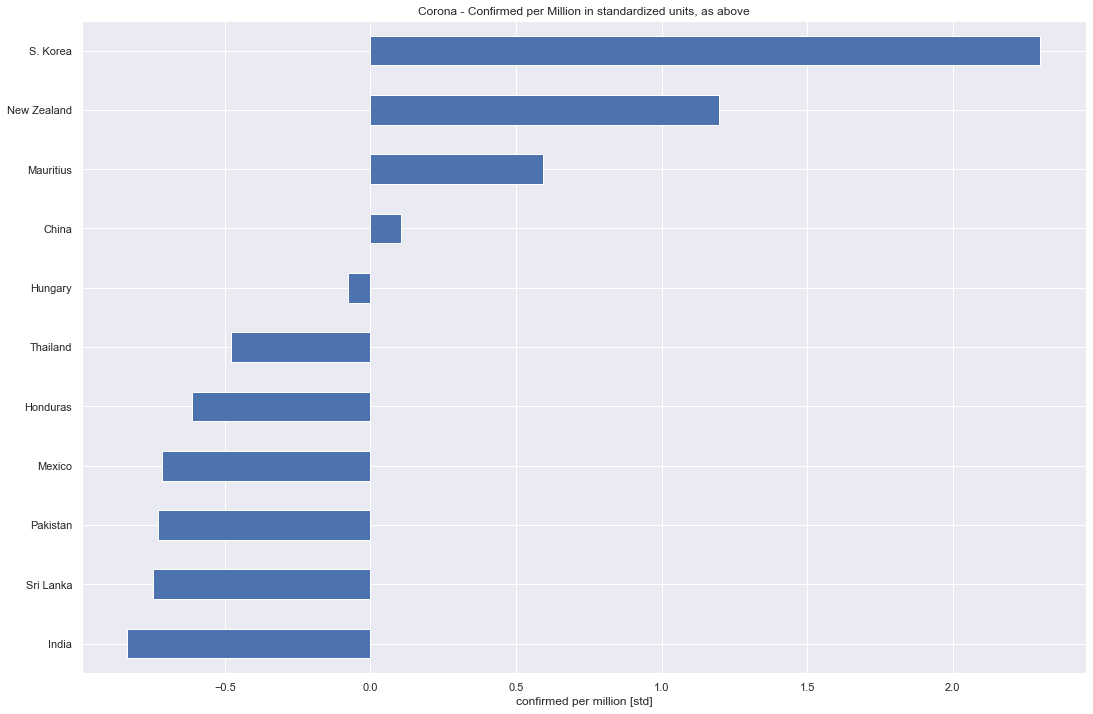

In [1521]:
plt.figure(figsize=(18,12))
plt.title ('Corona - Confirmed per Million in standardized units, as above')
plt.xlabel('confirmed per million [std]')
#df_no_extrems['confirmed_per_M'].sort_values().plot(kind='barh')
std_values = standardize(df_no_extrems['confirmed_per_M'])
_= std_values.sort_values().plot(kind='barh')

